Example of 'preprocess' step in which an input file describing the study region is discretized in H3 cells, visualized, and exported back.

In [1]:
import geopandas
import h3
import folium
import matplotlib
import json
from shapely.geometry import Polygon
import importlib
import numpy

import sys
sys.path.append('../')

import config
from config import *

import myDiscretization
import myDiscretization.folium
import myDiscretization.travel_times.graphhopper


Import and visualize the original region:

In [2]:
rj_gdf = geopandas.read_file(os.path.join(ENTR_DATA_PATH,'rj/rj.shp')).reset_index()
rj_gdf.plot()

<AxesSubplot:>

Discretize it using the generate_discretization function. This uses Uber's H3 library function the find the H3 cells that better aproximate the study region in the given resolution.

In [3]:
help(myDiscretization.generate_discretization)

Help on function generate_discretization in module myDiscretization.interface:

generate_discretization(gdf, shape='hexagons', h3_discretization_level=6, export_friendly=False)
    Generate an enriched, discretized GeoDataFrame from the original geodataframe. The GeoDataFrame returned should work seamlessly with
        other functions provided within this module.
    
    Params:
        gdf : (string, GeoDataFrame) - a path to a GeoDataFrame or a GeoDataFrame object
        shape : ('rectangles', 'hexagons', 'none', False) - the shape in which the space should be discretized. If 'none' or False, no discretization is done
        h3_discretization_level - if using 'hexagons', this sets the resolution level passed to the H3 library. A bigger number means smaller hexagons. Valid range [0,15]
        export_friendly : (bool) - if True, the returned geodataframe is transformed to contain only columns that can be easily exported



<AxesSubplot:>

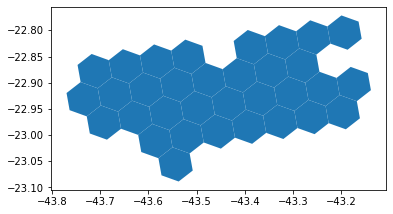

In [4]:
hex_gdf = myDiscretization.generate_discretization(rj_gdf, shape = 'hexagons', h3_discretization_level = 6)
hex_gdf.plot()

The return is also a geodataframe, in the following format:

In [5]:
hex_gdf.head(3)

,geometry,area,center_lat,center_lon,neighbors,h3_index
0,"POLYGON ((-43.29383 -22.80173, -43.28744 -22.8...",37.292598,-22.813470,-43.258254,"{25, 11, 9}",86a8a06f7ffffff
1,"POLYGON ((-43.35586 -22.99566, -43.36224 -22.9...",37.176559,-22.983908,-43.391438,"{10, 19, 29, 23}",86a8a0757ffffff
2,"POLYGON ((-43.55017 -23.02319, -43.55654 -22.9...",37.149336,-23.011396,-43.585740,"{13, 3, 5, 7}",86a8a039fffffff


We can visualize the discretization in more detail by using folium, for example

In [6]:
myDiscretization.folium.visualize_h3(hex_gdf)

We can then export the discretization to file in all the formats supported by geopandas / fiona

In [7]:
export_gdf = myDiscretization.to_export_friendly(hex_gdf)

In [8]:
export_gdf.to_file(os.path.join(TRTD_DATA_PATH, 'rj_hex/sh/'), driver='ESRI Shapefile')

In [9]:
export_gdf.to_file(os.path.join( TRTD_DATA_PATH, 'rj_hex/rj_hex.geojson'), driver='GeoJSON')

A list of all supported formats:

In [10]:
import fiona; fiona.supported_drivers

{'AeronavFAA': 'r',
 'ARCGEN': 'r',
 'BNA': 'raw',
 'DXF': 'raw',
 'CSV': 'raw',
 'OpenFileGDB': 'r',
 'ESRI Shapefile': 'raw',
 'GeoJSON': 'rw',
 'GPKG': 'rw',
 'GML': 'raw',
 'GPX': 'raw',
 'GPSTrackMaker': 'raw',
 'Idrisi': 'r',
 'MapInfo File': 'raw',
 'DGN': 'raw',
 'PCIDSK': 'r',
 'S57': 'r',
 'SEGY': 'r',
 'SUA': 'r'}

For reimporting, simply use geopandas:

In [11]:
t1 = geopandas.read_file(os.path.join( TRTD_DATA_PATH, 'rj_hex/rj_hex.geojson')).reset_index()
t1.head(3)

,index,area,center_lat,center_lon,neighbors,h3_index,geometry
0,0,37.292598,-22.813470,-43.258254,25-11-9,86a8a06f7ffffff,"POLYGON ((-43.29383 -22.80173, -43.28744 -22.8..."
1,1,37.176559,-22.983908,-43.391438,10-19-29-23,86a8a0757ffffff,"POLYGON ((-43.35586 -22.99566, -43.36224 -22.9..."
2,2,37.149336,-23.011396,-43.585740,13-3-5-7,86a8a039fffffff,"POLYGON ((-43.55017 -23.02319, -43.55654 -22.9..."


In [12]:
t2 = geopandas.read_file(os.path.join( TRTD_DATA_PATH, 'rj_hex/rj_hex.geojson')).reset_index()
t2.head(3)

,index,area,center_lat,center_lon,neighbors,h3_index,geometry
0,0,37.292598,-22.813470,-43.258254,25-11-9,86a8a06f7ffffff,"POLYGON ((-43.29383 -22.80173, -43.28744 -22.8..."
1,1,37.176559,-22.983908,-43.391438,10-19-29-23,86a8a0757ffffff,"POLYGON ((-43.35586 -22.99566, -43.36224 -22.9..."
2,2,37.149336,-23.011396,-43.585740,13-3-5-7,86a8a039fffffff,"POLYGON ((-43.55017 -23.02319, -43.55654 -22.9..."


We can also obtain a distance matrix for these hexagons.

You must first set your graphhopper api key. Try not use all your credits at once! Be careful with large areas and/or small cells. 

In [13]:
#my key is saved in the config file, but you can set it however you like
myDiscretization.travel_times.graphhopper.set_graphhopper_key(config.GH_KEY)

In [14]:
dist_matrix = myDiscretization.travel_times.graphhopper.distance_matrix_from_gdf(hex_gdf)
dist_matrix

KeyError: 'times'

We can then cache it into a file, so we don't spend too many credits over time

In [15]:
numpy.save(os.path.join( TRTD_DATA_PATH, 'rj_hex/travel_times.npy'), dist_matrix, allow_pickle = True)

We can then read it back easily:

In [16]:
dist_matrix_read = numpy.load(os.path.join( TRTD_DATA_PATH, 'rj_hex/travel_times.npy'), allow_pickle = True)
dist_matrix_read

array([[   0., 2961., 2887., ..., 2779., 5420.,  795.],
       [2951.,    0., 3061., ...,  938., 3094., 2913.],
       [2863., 3099.,    0., ..., 3322., 4338., 3390.],
       ...,
       [2747.,  952., 3278., ...,    0., 3411., 2708.],
       [5409., 3097., 4237., ..., 3396.,    0., 5371.],
       [ 891., 2892., 3374., ..., 2710., 5351.,    0.]])

Finally, we can calculate overlay between different discretizations and apply regressors to our file:

In [5]:
regressor = geopandas.read_file(os.path.join(ENTR_DATA_PATH,'Bairros_rio_de_janeiro.shp'))
regressor = regressor.set_crs(epsg=29183)
regressor = regressor.to_crs(epsg=4326)
regressor = regressor[['area','geometry']].rename({'area':'regressor_value'},axis=1)
regressor.head()

,regressor_value,geometry
0,1.705684e+06,"MULTIPOLYGON (((-43.10530 -22.74839, -43.10531..."
1,4.056403e+06,"MULTIPOLYGON (((-43.17133 -22.77613, -43.17133..."
2,9.780466e+05,"MULTIPOLYGON (((-43.18878 -22.78270, -43.18876..."
3,1.895742e+07,"MULTIPOLYGON (((-43.22767 -22.78325, -43.22761..."
4,1.672546e+06,"POLYGON ((-43.18002 -22.79891, -43.18018 -22.7..."


In [8]:
r_df = myDiscretization.addRegressorWeithedAverage(hex_gdf,regressor)

In [9]:
r_df.head()

,geometry,area,center_lat,center_lon,neighbors,h3_index,regressor_value
0,"POLYGON ((-43.29383 -22.80173, -43.32939 -22.7...",37.283910,-22.822738,-43.323011,"{9, 11, 12, 7}",86a8a06e7ffffff,3.749308e+06
1,"POLYGON ((-43.22631 -22.97717, -43.23270 -22.9...",37.194104,-22.965445,-43.261895,"{32, 29, 22, 30}",86a8a0637ffffff,2.282020e+07
2,"POLYGON ((-43.50453 -22.91588, -43.46896 -22.9...",37.230357,-22.894918,-43.475335,"{4, 21, 25, 27, 28}",86a8a0667ffffff,3.079088e+07
3,"POLYGON ((-43.72799 -22.96416, -43.69879 -22.9...",37.193232,-22.931423,-43.734350,"{24, 10, 6}",86a8a021fffffff,1.087478e+08
4,"POLYGON ((-43.55283 -22.83858, -43.54646 -22.8...",37.257117,-22.850374,-43.517272,"{2, 28, 13}",86a8a066fffffff,6.140993e+07
